In [8]:
# import data science and visualization libraries
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import sagemaker

In [9]:
print(sagemaker.__version__)

2.70.0


In [14]:
# download the raw data and unzip
!wget -P ./data/ https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
!gunzip ./data/covtype.data.gz

--2022-01-11 08:40:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11240707 (11M) [application/x-httpd-php]
Saving to: ‘./data/covtype.data.gz’

covtype.data.gz     100%[===================>]  10.72M  12.8MB/s    in 0.8s    

2022-01-11 08:40:09 (12.8 MB/s) - ‘./data/covtype.data.gz’ saved [11240707/11240707]



In [15]:
# read the csv and extract features and labels
covtype = pd.read_csv('./data/covtype.data', delimiter=',', dtype='float32').values
covtype

array([[2.590e+03, 5.600e+01, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        5.000e+00],
       [2.804e+03, 1.390e+02, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       [2.785e+03, 1.550e+02, 1.800e+01, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       ...,
       [2.386e+03, 1.590e+02, 1.700e+01, ..., 0.000e+00, 0.000e+00,
        3.000e+00],
       [2.384e+03, 1.700e+02, 1.500e+01, ..., 0.000e+00, 0.000e+00,
        3.000e+00],
       [2.383e+03, 1.650e+02, 1.300e+01, ..., 0.000e+00, 0.000e+00,
        3.000e+00]], dtype=float32)

In [16]:
covtype.shape

(581011, 55)

In [17]:
covtype_features, covtype_labels = covtype[:, :54], covtype[:, 54]
# transform labels to 0 index
covtype_labels -= 1

# shuffle and split into train and test sets
np.random.seed(0)
train_features, test_features, train_labels, test_labels = train_test_split(
    covtype_features, covtype_labels, test_size=0.2
)
# further split the test set into validation and test sets
val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5
)

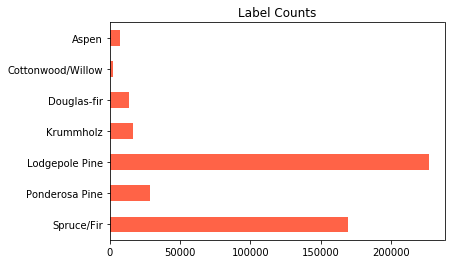

In [18]:
# assign label names and count label frequencies
label_map = {
    0: "Spruce/Fir",
    1: "Lodgepole Pine",
    2: "Ponderosa Pine",
    3: "Cottonwood/Willow",
    4: "Aspen",
    5: "Douglas-fir",
    6: "Krummholz",
}
label_counts = (
    pd.DataFrame(data=train_labels)[0]
    .map(label_map)
    .value_counts(sort=False)
    .sort_index(ascending=False)
)
label_counts.plot(kind="barh", color="tomato", title="Label Counts")

In [16]:
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# instantiate the LinearLearner estimator object
multiclass_estimator = sagemaker.LinearLearner(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",
    predictor_type="multiclass_classifier",
    num_classes=7,
)

In [20]:
# wrap data in RecordSet objects
train_records = multiclass_estimator.record_set(train_features, train_labels, channel="train")
val_records = multiclass_estimator.record_set(val_features, val_labels, channel="validation")
test_records = multiclass_estimator.record_set(test_features, test_labels, channel="test")

NameError: name 'multiclass_estimator' is not defined

In [ ]:
# start a training job
multiclass_estimator.fit([train_records, val_records, test_records])

In [20]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label["predicted_label"].float32_tensor.values
    test_preds = np.concatenate(
        [np.array([extract_label(x) for x in batch]) for batch in prediction_batches]
    )
    test_preds = test_preds.reshape((-1,))

    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]

    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(
            test_preds == target_label, test_labels == target_label
        ).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({"recall": recall_per_class, "class_label": classes})
    recall.sort_values("class_label", ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(
        label_mapper(test_labels),
        label_mapper(test_preds),
        rownames=["Actuals"],
        colnames=["Predictions"],
        normalize="index",
    )

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="YlGnBu").set_title(
        "Confusion Matrix"
    )
    ax = recall.plot(
        kind="barh", x="class_label", y="recall", color="steelblue", title="Recall", legend=False
    )
    ax.set_ylabel("")
    print("Accuracy: {:.3f}".format(accuracy))

In [ ]:
# deploy a model hosting endpoint
multiclass_predictor = multiclass_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge"
)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------

In [ ]:
# evaluate metrics of the model trained with default hyperparameters
evaluate_metrics(multiclass_predictor, test_features, test_labels)

In [19]:
# instantiate the LinearLearner estimator object
balanced_multiclass_estimator = sagemaker.LinearLearner(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",
    predictor_type="multiclass_classifier",
    num_classes=7,
    balance_multiclass_weights=True,
)

In [21]:
# wrap data in RecordSet objects
train_records = balanced_multiclass_estimator.record_set(train_features, train_labels, channel="train")
val_records = balanced_multiclass_estimator.record_set(val_features, val_labels, channel="validation")
test_records = balanced_multiclass_estimator.record_set(test_features, test_labels, channel="test")

In [ ]:
# start a training job
balanced_multiclass_estimator.fit([train_records, val_records, test_records])

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-01-11 08:41:23 Starting - Starting the training job...
2022-01-11 08:41:47 Starting - Launching requested ML instancesProfilerReport-1641890482: InProgress
.

In [ ]:
# deploy a model hosting endpoint
balanced_multiclass_predictor = balanced_multiclass_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge"
)

In [ ]:
# evaluate metrics of the model trained with balanced class weights
evaluate_metrics(balanced_multiclass_predictor, test_features, test_labels)

In [ ]:
# delete endpoints
multiclass_predictor.delete_endpoint()
balanced_multiclass_predictor.delete_endpoint()